In [1]:
from gtm import *

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# GTM Package including GTM and the plot functions
from gtm import *
# Sample Copulas Package
import pyvinecopulib as pv
import numpy as np
# Other Stuff
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Sample Data

In [4]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [5]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76661/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76661/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76661/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

In [6]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [7]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76661/2452348847.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76661/2452348847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76661/2452348847.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

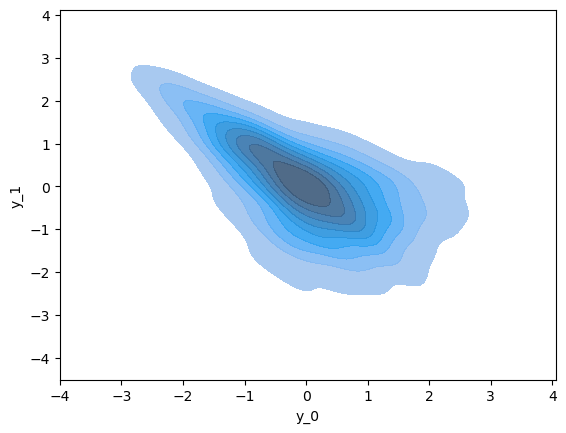

In [8]:
sns.kdeplot(x=simulated_data_train[:, 0], y=simulated_data_train[:, 1], fill=True, alpha=0.9)
plt.xlabel("y_0")
plt.ylabel("y_1")
plt.show()

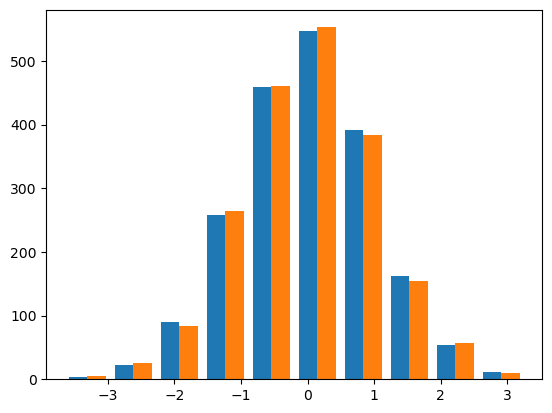

In [9]:
plt.hist(simulated_data_train.T)
plt.show()

In [10]:
class Copula_2D_Dataset(Dataset):
    def __init__(self, data):
        
        # First Dimension (N) needs to be the samples
        # Second Dimension (D) is the dimensionality of the data
        self.data = data
    
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
# Create dataset and DataLoader
dataset_train = Copula_2D_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Copula_2D_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

In [11]:
# Here you can see that we load the full data, so not batches
# Model is just implemented with dataloaders because that is eeded for huge datasets in bioinformatics
data_iter = iter(dataloader_train)
sample = next(data_iter)
sample.size()

torch.Size([2000, 2])

### 2. Define Model

In [12]:
model = GTM(
    transformation_spline_range=list([[-15], [15]]), 
    degree_decorrelation=40,
    degree_transformations=15,
    num_decorr_layers=3,
    num_trans_layers=1,
    number_variables=2,
    calc_method_bspline="deBoor",
    device="cpu") 

### 3. Hyperparameter Tune and Train Model

In [13]:
study = model.hyperparameter_tune_penalties( 
                                train_dataloader=dataloader_train, 
                                validate_dataloader=dataloader_validate, 
                                penvalueridge = [0], #["sample"],
                                penfirstridge = ["sample"],
                                pensecondridge = ["sample"],
                                ctm_pensecondridge = ["sample"],
                                lambda_penalty_params = [0], #["sample"],
                                train_covariates=False, 
                                validate_covariates=False, 
                                adaptive_lasso_weights_matrix = False,
                                learning_rate=1, 
                                iterations=1000, 
                                patience=5, 
                                min_delta=1e-7, 
                                optimizer='LBFGS', 
                                lambda_penalty_mode="square", 
                                objective_type="negloglik", 
                                seperate_copula_training=False,
                                max_batches_per_iter=False,
                                tuning_mode="optuna",
                                cross_validation_folds=False,
                                random_state_KFold=42,
                                device=None,
                                pretrained_transformation_layer=False,
                                n_trials=20,
                                temp_folder=".", 
                                study_name=None)
    
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            study.best_params["penfirstridge"],
                            study.best_params["pensecondridge"],
                            study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params=False

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 16:20:40,385] A new study created in RDB with name: no-name-107354f9-5f63-4bfa-8998-bc62743d667f


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.28438958442945833   pensecondridge_opt: 2.4833229074427727   ctm_pensecondridge_opt: 0.033565140936719945   lambda_penalty_params_opt: 0


  5%|▌         | 53/1000 [00:01<00:21, 44.10it/s]
[I 2025-05-19 16:20:42,272] Trial 0 finished with value: -2.594924211502075 and parameters: {'penfirstridge': 0.28438958442945833, 'pensecondridge': 2.4833229074427727, 'ctm_pensecondridge': 0.033565140936719945}. Best is trial 0 with value: -2.594924211502075.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 2.0084190777092886e-06   pensecondridge_opt: 0.00030332258839900207   ctm_pensecondridge_opt: 0.06819869417393752   lambda_penalty_params_opt: 0


  4%|▍         | 45/1000 [00:01<00:21, 44.09it/s]
[I 2025-05-19 16:20:43,326] Trial 1 finished with value: -2.5490660667419434 and parameters: {'penfirstridge': 2.0084190777092886e-06, 'pensecondridge': 0.00030332258839900207, 'ctm_pensecondridge': 0.06819869417393752}. Best is trial 1 with value: -2.5490660667419434.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 1.963766968129687e-06   pensecondridge_opt: 7.339331817707991e-07   ctm_pensecondridge_opt: 1.31241408883791e-06   lambda_penalty_params_opt: 0


  3%|▎         | 34/1000 [00:00<00:21, 43.92it/s]
[I 2025-05-19 16:20:44,134] Trial 2 finished with value: -2.548696756362915 and parameters: {'penfirstridge': 1.963766968129687e-06, 'pensecondridge': 7.339331817707991e-07, 'ctm_pensecondridge': 1.31241408883791e-06}. Best is trial 2 with value: -2.548696756362915.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.00039279743993137097   pensecondridge_opt: 1.87626736492465e-05   ctm_pensecondridge_opt: 2.68259464671383e-06   lambda_penalty_params_opt: 0


  4%|▎         | 36/1000 [00:00<00:24, 39.31it/s]
[I 2025-05-19 16:20:45,142] Trial 3 finished with value: -2.5498623847961426 and parameters: {'penfirstridge': 0.00039279743993137097, 'pensecondridge': 1.87626736492465e-05, 'ctm_pensecondridge': 2.68259464671383e-06}. Best is trial 2 with value: -2.548696756362915.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 4.652754416555258   pensecondridge_opt: 0.42341356267854285   ctm_pensecondridge_opt: 2.5187727267276702e-06   lambda_penalty_params_opt: 0


  4%|▎         | 36/1000 [00:00<00:21, 45.30it/s]
[I 2025-05-19 16:20:45,972] Trial 4 finished with value: -2.6261978149414062 and parameters: {'penfirstridge': 4.652754416555258, 'pensecondridge': 0.42341356267854285, 'ctm_pensecondridge': 2.5187727267276702e-06}. Best is trial 2 with value: -2.548696756362915.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 6.779168621261976e-07   pensecondridge_opt: 1.8383179254327735   ctm_pensecondridge_opt: 7.25723022524715e-05   lambda_penalty_params_opt: 0


  7%|▋         | 74/1000 [00:01<00:20, 44.46it/s]
[I 2025-05-19 16:20:47,668] Trial 5 finished with value: -2.5725741386413574 and parameters: {'penfirstridge': 6.779168621261976e-07, 'pensecondridge': 1.8383179254327735, 'ctm_pensecondridge': 7.25723022524715e-05}. Best is trial 2 with value: -2.548696756362915.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 1.1115455357511108e-05   pensecondridge_opt: 0.00078380479146537   ctm_pensecondridge_opt: 1.4845139243135275   lambda_penalty_params_opt: 0


  6%|▌         | 55/1000 [00:01<00:24, 38.95it/s]
[I 2025-05-19 16:20:49,114] Trial 6 finished with value: -2.542623996734619 and parameters: {'penfirstridge': 1.1115455357511108e-05, 'pensecondridge': 0.00078380479146537, 'ctm_pensecondridge': 1.4845139243135275}. Best is trial 6 with value: -2.542623996734619.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.16658104621037093   pensecondridge_opt: 2.581986318406374e-07   ctm_pensecondridge_opt: 1.17615429863086   lambda_penalty_params_opt: 0


  3%|▎         | 34/1000 [00:00<00:21, 45.19it/s]
[I 2025-05-19 16:20:49,897] Trial 7 finished with value: -2.551614284515381 and parameters: {'penfirstridge': 0.16658104621037093, 'pensecondridge': 2.581986318406374e-07, 'ctm_pensecondridge': 1.17615429863086}. Best is trial 6 with value: -2.542623996734619.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 1.0061939288843358e-06   pensecondridge_opt: 3.033524160599254   ctm_pensecondridge_opt: 0.21658438356359255   lambda_penalty_params_opt: 0


  2%|▏         | 16/1000 [00:00<00:22, 43.54it/s]
[I 2025-05-19 16:20:50,296] Trial 8 finished with value: -2.670022964477539 and parameters: {'penfirstridge': 1.0061939288843358e-06, 'pensecondridge': 3.033524160599254, 'ctm_pensecondridge': 0.21658438356359255}. Best is trial 6 with value: -2.542623996734619.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.0007485022418175467   pensecondridge_opt: 3.220583008861958e-05   ctm_pensecondridge_opt: 9.654573361364172   lambda_penalty_params_opt: 0


  8%|▊         | 85/1000 [00:02<00:22, 40.71it/s]
[I 2025-05-19 16:20:52,416] Trial 9 finished with value: -2.5311591625213623 and parameters: {'penfirstridge': 0.0007485022418175467, 'pensecondridge': 3.220583008861958e-05, 'ctm_pensecondridge': 9.654573361364172}. Best is trial 9 with value: -2.5311591625213623.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 4.1887216639300043e-07   pensecondridge_opt: 3.4023616657451407e-07   ctm_pensecondridge_opt: 6.27684141593057   lambda_penalty_params_opt: 0


  4%|▍         | 41/1000 [00:00<00:22, 43.20it/s]
[I 2025-05-19 16:20:53,403] Trial 10 finished with value: -2.5493924617767334 and parameters: {'penfirstridge': 4.1887216639300043e-07, 'pensecondridge': 3.4023616657451407e-07, 'ctm_pensecondridge': 6.27684141593057}. Best is trial 9 with value: -2.5311591625213623.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.0009723818398114384   pensecondridge_opt: 0.02379758643395408   ctm_pensecondridge_opt: 3.1430354830508005   lambda_penalty_params_opt: 0


  5%|▌         | 53/1000 [00:01<00:22, 41.30it/s]
[I 2025-05-19 16:20:54,722] Trial 11 finished with value: -2.53731107711792 and parameters: {'penfirstridge': 0.0009723818398114384, 'pensecondridge': 0.02379758643395408, 'ctm_pensecondridge': 3.1430354830508005}. Best is trial 9 with value: -2.5311591625213623.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.0053169304158288576   pensecondridge_opt: 0.13924219704715846   ctm_pensecondridge_opt: 3.0355691096456887   lambda_penalty_params_opt: 0


  4%|▍         | 45/1000 [00:01<00:24, 38.49it/s]
[I 2025-05-19 16:20:55,927] Trial 12 finished with value: -2.537196636199951 and parameters: {'penfirstridge': 0.0053169304158288576, 'pensecondridge': 0.13924219704715846, 'ctm_pensecondridge': 3.0355691096456887}. Best is trial 9 with value: -2.5311591625213623.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 10.743429269745459   pensecondridge_opt: 0.005084217919644192   ctm_pensecondridge_opt: 3.040362230983144   lambda_penalty_params_opt: 0


  6%|▋         | 64/1000 [00:01<00:20, 45.50it/s]
[I 2025-05-19 16:20:57,373] Trial 13 finished with value: -2.625471830368042 and parameters: {'penfirstridge': 10.743429269745459, 'pensecondridge': 0.005084217919644192, 'ctm_pensecondridge': 3.040362230983144}. Best is trial 9 with value: -2.5311591625213623.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.00039027092295355626   pensecondridge_opt: 1.6412610308711813e-07   ctm_pensecondridge_opt: 0.004126426152284246   lambda_penalty_params_opt: 0


  6%|▋         | 63/1000 [00:01<00:21, 44.60it/s]
[I 2025-05-19 16:20:58,821] Trial 14 finished with value: -2.540879011154175 and parameters: {'penfirstridge': 0.00039027092295355626, 'pensecondridge': 1.6412610308711813e-07, 'ctm_pensecondridge': 0.004126426152284246}. Best is trial 9 with value: -2.5311591625213623.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.4448968448752145   pensecondridge_opt: 4.5693081435745006e-05   ctm_pensecondridge_opt: 0.0015723517279700719   lambda_penalty_params_opt: 0


  3%|▎         | 26/1000 [00:00<00:27, 35.49it/s]
[I 2025-05-19 16:20:59,590] Trial 15 finished with value: -2.5861620903015137 and parameters: {'penfirstridge': 0.4448968448752145, 'pensecondridge': 4.5693081435745006e-05, 'ctm_pensecondridge': 0.0015723517279700719}. Best is trial 9 with value: -2.5311591625213623.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.0003089809743235636   pensecondridge_opt: 0.08416684861041288   ctm_pensecondridge_opt: 0.0011000591798524984   lambda_penalty_params_opt: 0


  5%|▍         | 48/1000 [00:01<00:21, 44.71it/s]
[I 2025-05-19 16:21:00,699] Trial 16 finished with value: -2.536821126937866 and parameters: {'penfirstridge': 0.0003089809743235636, 'pensecondridge': 0.08416684861041288, 'ctm_pensecondridge': 0.0011000591798524984}. Best is trial 9 with value: -2.5311591625213623.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.0008584477537332587   pensecondridge_opt: 9.839294823489888   ctm_pensecondridge_opt: 0.0004216542192092381   lambda_penalty_params_opt: 0


  8%|▊         | 77/1000 [00:01<00:21, 43.63it/s]
[I 2025-05-19 16:21:02,500] Trial 17 finished with value: -2.6141059398651123 and parameters: {'penfirstridge': 0.0008584477537332587, 'pensecondridge': 9.839294823489888, 'ctm_pensecondridge': 0.0004216542192092381}. Best is trial 9 with value: -2.5311591625213623.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 4.37047305277996e-05   pensecondridge_opt: 0.00888472219612664   ctm_pensecondridge_opt: 0.0016912198106834476   lambda_penalty_params_opt: 0


  4%|▎         | 36/1000 [00:00<00:26, 37.04it/s]
[I 2025-05-19 16:21:03,511] Trial 18 finished with value: -2.540163040161133 and parameters: {'penfirstridge': 4.37047305277996e-05, 'pensecondridge': 0.00888472219612664, 'ctm_pensecondridge': 0.0016912198106834476}. Best is trial 9 with value: -2.5311591625213623.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.002983752722069958   pensecondridge_opt: 6.7581363441336206e-06   ctm_pensecondridge_opt: 1.1543486192800585   lambda_penalty_params_opt: 0


  4%|▎         | 36/1000 [00:00<00:21, 44.33it/s]
[I 2025-05-19 16:21:04,360] Trial 19 finished with value: -2.5508906841278076 and parameters: {'penfirstridge': 0.002983752722069958, 'pensecondridge': 6.7581363441336206e-06, 'ctm_pensecondridge': 1.1543486192800585}. Best is trial 9 with value: -2.5311591625213623.


hyperparameter_tuning done


In [14]:
# pretrain the marginal transformations
_ = model.pretrain_tranformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_params=penalty_params)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_model/gtm.py:295: UserWarning: Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.
  warnings.warn("Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.")
  6%|▌         | 55/1000 [00:00<00:11, 81.58it/s] 


In [15]:
# train the joint model
_ = model.__train__(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_params=penalty_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, lambda_penalty_params=lambda_penalty_params, 
                max_batches_per_iter=False)

  4%|▍         | 41/1000 [00:00<00:21, 43.65it/s]


### 4. Compare Fit to Benchmarks

In [16]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [17]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)  # 0 to do mean across dim 0 not globally
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [18]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.0136
KLD Gaussian Train Data:  0.1103
KLD Copula   Train Data:  -0.0002
KLD GTM      Test  Data:  0.0255
KLD Gaussian Test  Data:  0.1063
KLD Copula   Test  Data:  0.0004


### 5. Evaluate and Plot GTM Results

In [19]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(2000)

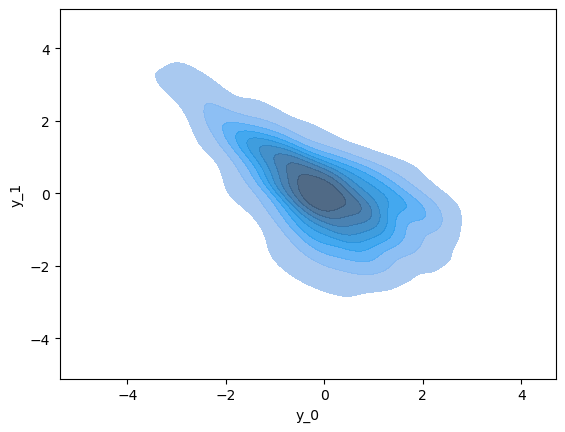

In [20]:
sns.kdeplot(x=synthetic_samples[:, 0], y=synthetic_samples[:, 1], fill=True, alpha=0.9)
plt.xlabel("y_0")
plt.ylabel("y_1")
plt.show()

"plot_marginals", "plot_metric_hist", "plot_metric_scatter", "plot_splines"

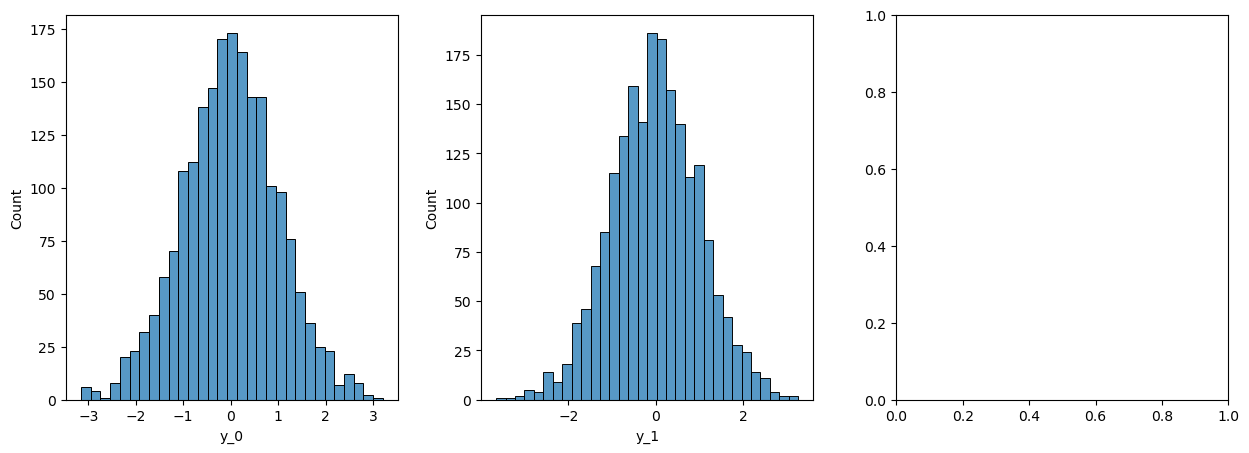

In [21]:
_ = plot_marginals(simulated_data_train)

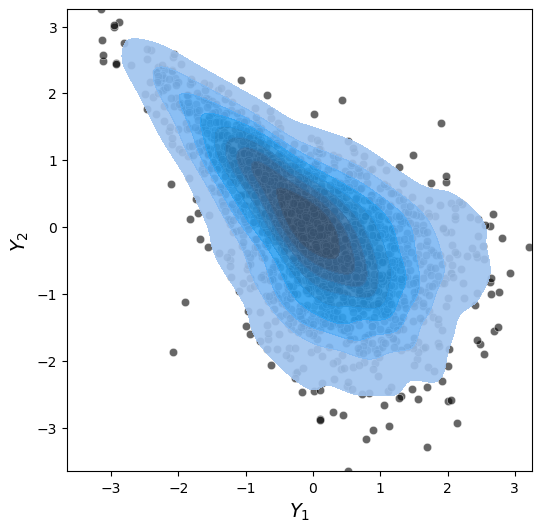

In [22]:
_ = plot_densities(simulated_data_train)

In [49]:
synthetic_samples = model.sample(2000)
p_matrix = model.compute_precision_matrix(synthetic_samples)

def p_to_corr(matrix):
            d = matrix.size(0)
            diag_sqrt = torch.diag(matrix) ** 0.5
            matrix_std_multiplied = np.matmul(torch.reshape(diag_sqrt, (d, 1)), torch.reshape(diag_sqrt, (1, d)))
            return -1 * matrix / matrix_std_multiplied

In [26]:
conditional_correlation_matrix_train = torch.stack([p_to_corr(p_matrix[obs_num,:,:]) for obs_num in range(p_matrix.size(0))])
conditional_correlation = conditional_correlation_matrix_train[:,0,1]

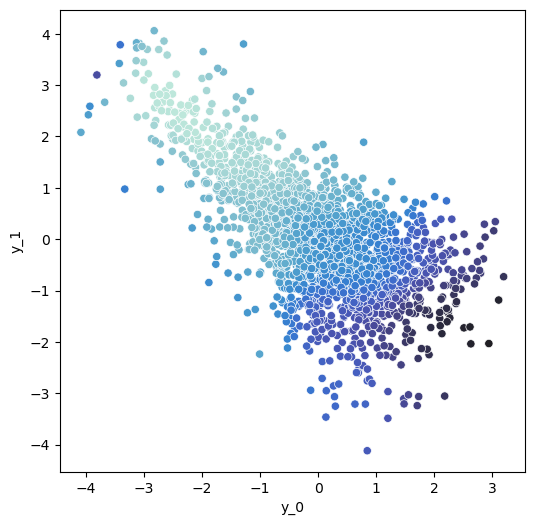

In [28]:
_ = plot_metric_scatter(data=synthetic_samples,metric=conditional_correlation)

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76661/513232434.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, spline_num],


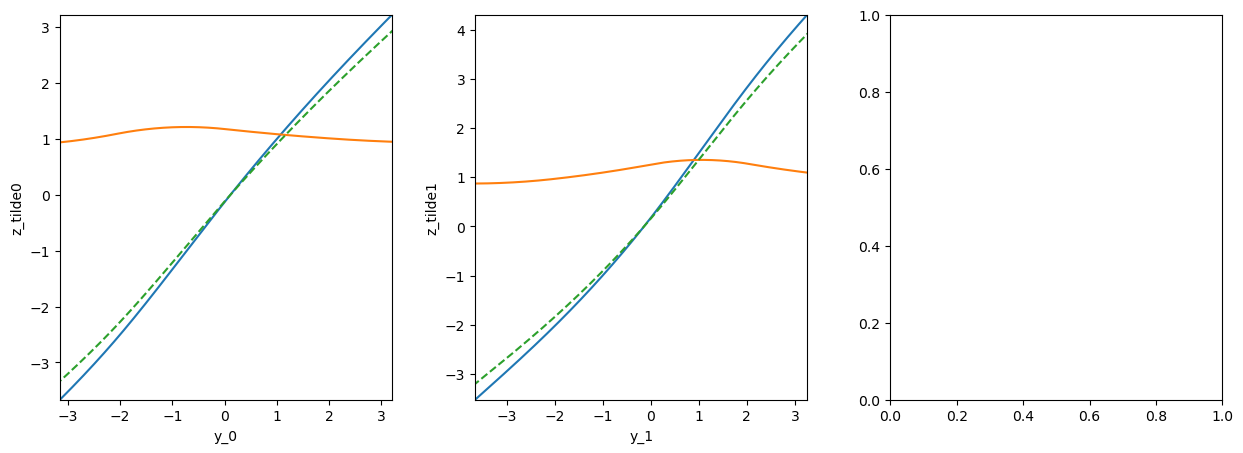

In [46]:
_ = plot_splines(model.transformation,simulated_data_train)

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76661/513232434.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


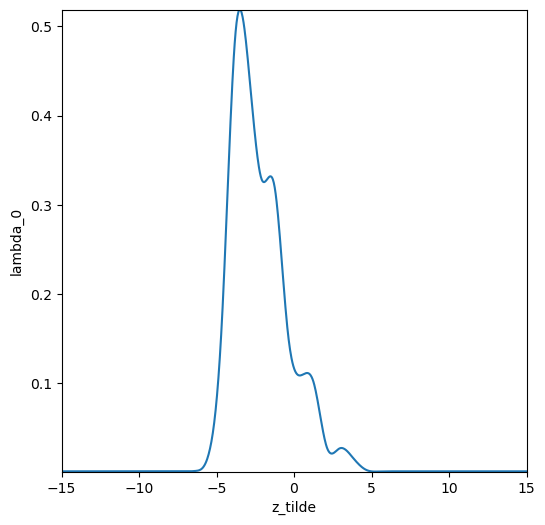

In [45]:
_ = plot_splines(model.decorrelation_layers[0],simulated_data_train)

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76661/513232434.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


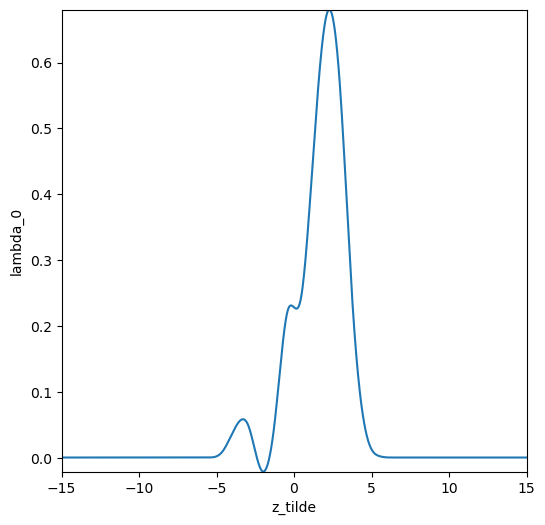

In [47]:
_ = plot_splines(model.decorrelation_layers[1],simulated_data_train)

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76661/513232434.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


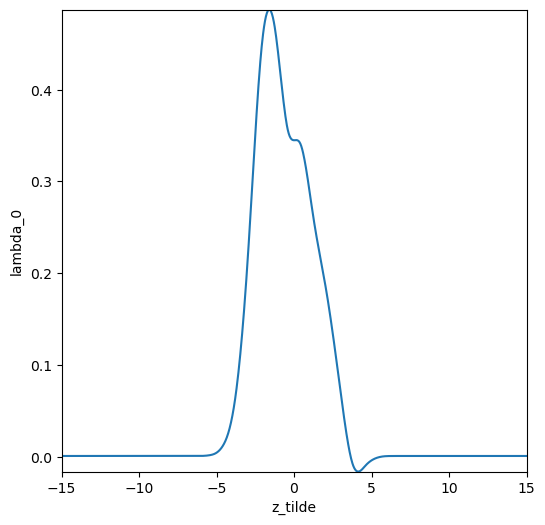

In [48]:
_ = plot_splines(model.decorrelation_layers[2],simulated_data_train)